# Booking Hotels Ranking

# Tables des matières

* [Introduction](#Introduction)
* [Acquisition des données](#Acquisition-des-données)
* [Nettoyage des données et preprocessing](#)
* [Sélection et entrainement du modèle](#)
* [Exploitation du prédicteur](#)

# Introduction

Projet réalisé sur le site [Booking.com](https://www.booking.com/index.en-gb.html?label=gen173nr-1BCAEoggI46AdIM1gEaE2IAQGYAQm4ARfIAQzYAQHoAQGIAgGoAgO4AsiE4Z0GwAIB0gIkZTYzNDYwZjAtYzE5Yy00YWMzLWEzNWItZjkzNDlkNmU1ZDBl2AIF4AIB&sid=7ba9f340e388bcc1c3db52ff34b02dd7&keep_landing=1&sb_price_type=total).

**Problématique** : Comment prédire efficacement le prix d'une chambre d'hotel en fonction de ses caractéristiques ?

# Acquisition des données

Voir `scraping.py`

Récupération des données pour une ville donnée (*Paris*) à une date donnée (*15 Janvier 2023*).


<img src="Capture_seach.PNG" width="800" /> ![Booking](img/Capture_search.PNG)

![Hotels](img/Capture_Hotels.PNG)

Fonction *open_hotels* qui permet de récupérer différentes informations : 
- l'identifiant de l'hôtel
- le nom de l'hôtel
- l'adresse de l'hôtel
- la note de l'hôtel par les utilisateurs de *Booking*
- le nombre d'étoiles
- le type (si c'est un hôtel, appartement ...)
- le nombre de commentaires laissé sur cet hôtel par les utilisateurs de *Booking*
- les équipements de chaque chambre et de l'hôtel (salle de bain, chambre, ascenseur, parking, ...)
- les notes attribués aux différents services de l'hôtel (le personnel, le confort, le wifi, le rapport qualité-prix, ...)
- l'identifiant de la chambre
- le nom de la chambre
- la taille de la chambre
- **le prix de la chambre** (variable cible)
- le nombre de personnes puvant être accueillis dans la chambre
- la présence d'une promotion sur le prix récupéré
- information sur le petit déjeuner (inclu, prix, ...)
- les possibilités d'annulation (gratuite, possibilité de reprogrammer, ...)
- le moment de payer (à l'avance, sur place, ...)

Sortie json : Booking_Hotels_Paris.json (si la ville demandée est Paris)

![Rooms](img/Capture_Rooms.PNG)

# Nettoyage des données et preprocessing 

Voir `preprocessing.py`

Nettoyage des données portant sur :
- le prix
- l'adresse
- le nombre de commentaires
- la note 
- l'annulation 
- le petit déjeuner
- la taille de la chambre 

Création de données : 
- les équipements des chambres et des hôtels
- les notes attribués aux services de l'hôtel
- une variable binaire qui informe sur la présence d'une promotion
- une variable binaire qui informe si l'annulation est gratuite
- une varaible binaire qui informe si un prépaiement est possible
- une variable binaire qui informe si le petit déjeuner et inclu
- le prix du petit déjeuner s'il n'est pas inclu

# Statistiques descriptives

#### Importations librairies et données

In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor

from machine_learning import tableau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

from rich import print
from rich.table import Table 
with open('Booking_Hotels_cleaned.json', 'r') as read_content:
    data = json.load(read_content)

Paris = pd.DataFrame(data)

In [101]:
summary = Table(
    "Variable",
    "Type",
    "NA"
)

In [102]:
for col in Paris.columns:
    NA = '/'
    if Paris[col].isnull().sum() != 0:
        NA = Paris[col].isnull().sum()
    summary.add_row(
        str(col),
        str(Paris[col].dtype),
        str(NA)
    )

In [99]:
list_facilities = []
for i in range(0, len(Paris)):
    for keys, values in Paris["Hotel_facilities"][i].items():
        if keys not in list_facilities:
            list_facilities.append(keys)
            
Paris = Paris.drop(['Room_id', 'Room_name', 'Room_promo', 'Room_breakfast','Room_cancellation', 'Room_prepayment', 'Hotel_id', 'Hotel_Name', 'Hotel_address', 'Hotel_type', 'Hotel_facilities', 'Hotel_categories', 'Hotel_Street', 'Hotel_City', 'Hotel_Country'], axis=1)
for facility in list_facilities:
    Paris = Paris.drop(columns=[f'{facility}'])

#### Présentation du dataset et de la variable cible :

In [101]:
Paris.shape

(14736, 68)

In [103]:
summary

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━┓
┃ Variable                  ┃ Type    ┃ NA  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━┩
│ Room_price                │ int64   │ /   │
│ Room_sleeps               │ int64   │ /   │
│ Room_size                 │ float64 │ 323 │
│ Hotel_grade               │ float64 │ 7   │
│ Hotel_nb_reviews          │ int64   │ /   │
│ Hotel_stars               │ int64   │ /   │
│ Lift_bin                  │ int64   │ /   │
│ Luggage storage_bin       │ int64   │ /   │
│ No parking available._bin │ int64   │ /   │
│ Staff                     │ float64 │ 7   │
│ Facilities                │ float64 │ 7   │
│ Cleanliness               │ float64 │ 7   │
│ Comfort                   │ float64 │ 7   │
│ Value for money           │ float64 │ 7   │
│ Location                  │ float64 │ 7   │
│ Free WiFi                 │ float64 │ 145 │
│ Room_promo_bin            │ int64   │ /   │
│ Room_cancellation_bin     │ int64   │ /   │
│ Room_prepayment_bin       │ int64   │ /   │
│ Room_breakfast_bin        │ int64   │ /   │
│ Room_breakfast_price      │ float64 │ /   │
└───────────────────────────┴─────────┴─────┘

In [27]:
Paris_updated = Paris.dropna(axis=0)

In [112]:
Paris_updated.Hotel_type.value_counts()

Hotel                13924
Aparthotel             234
Hostel                  56
Apartments              46
Bed and breakfast       10
Name: Hotel_type, dtype: int64

In [28]:
i = Paris_updated[(Paris_updated.Hotel_type != 'Hotel')].index
Paris_updated = Paris_updated.drop(i)

In [83]:
Paris_updated.shape

(13924, 68)

<AxesSubplot:ylabel='Room_price'>

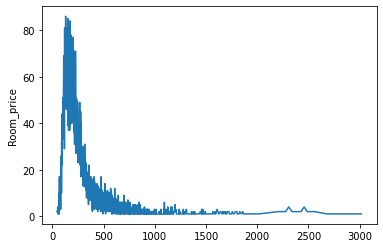

In [84]:
sns.lineplot(Paris_updated.Room_price.value_counts())

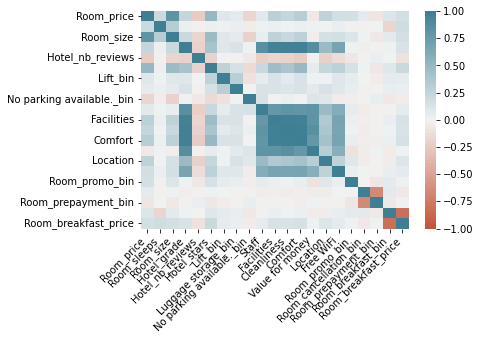

In [95]:
corr = Paris_updated.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Prix positivement corrélé avec :
 - Surface de la chambre
 - Nombre d'étoiles de l'hotel
 - Note globale de l'hotel
 - Notes de l'hotel par catégorie (aménagements, propreté, confort, localisation)
 - Nombre de couchages de la chambre
 
Prix négativement corrélé avec :
 - Nombre de reviews de l'hotel
 - Pas de parking

# Sélection et entrainement du modèle

### Settings

In [29]:
X = Paris_updated[
    [
    'Room_size', 
    'Room_promo_bin', 
    'Room_sleeps', 
    'Hotel_grade',
    'Staff', 
    'Facilities',
    'Cleanliness',
    'Comfort',
    'Value for money',
    'Location',
    'Free WiFi',
    'Hotel_nb_reviews',
    'Hotel_stars',
    'Room_cancellation_bin',
    'Room_prepayment_bin',
    'Room_breakfast_bin',
    'Room_breakfast_price',
    'Lift_bin',
    'Luggage storage_bin',
    'No parking available._bin'
    ]
]
y = Paris_updated['Room_price']

In [31]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [68]:
tableau

                                               Synthèse des modèles                                                
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃                      ┃                      ┃                      ┃ Cross-validation    ┃ Cross-validation     ┃
┃ Modèle               ┃ Train score          ┃ Test score           ┃ score               ┃ dispersion           ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ LinearRegression()   │ 0.7455055919874514   │ 0.7350750117008187   │ 0.7439929773643579  │ 0.015550983936590674 │
│ Lasso()              │ 0.7430490772671164   │ 0.7319042156616086   │ 0.7418520040323436  │ 0.015931237328124077 │
│ Ridge()              │ 0.7455049006087948   │ 0.7350702098431212   │ 0.7439954629353678  │ 0.015564364103001828 │
│ ElasticNet()         │ 0.7455025167923723   │ 0.7350588294483169   │ 0.7439897566225371  │ 0.015557146597396713 │
│ KNeighborsRegressor… │ 0.9932542216597539   │ 0.9201003389156811   │ 0.9218896129410432  │ 0.012894380895137714 │
│ GaussianProcessRegr… │ 0.9938432727921422   │ 0.5952212447693458   │ 0.5520618360030165  │ 0.04252545633178356  │
│ RandomForestRegress… │ 0.9917081505176722   │ 0.9671373723060579   │ 0.9668384215807089  │ 0.003389267259303931 │
│ SVR()                │ 0.6009683381710624   │ 0.6136104457840291   │ 0.5712356622463794  │ 0.00728300081648162  │
│ MLPRegressor()       │ 0.8442536006673922   │ 0.8283188702870439   │ 0.8491215264001049  │ 0.015469445249414269 │
│ BernoulliNB()        │ 0.016278847074595423 │ 0.008905486929043378 │ 0.01005458256989265 │ 0.00042826949119437… │
│ LogisticRegression() │ 0.010916403332375754 │ 0.008330939385234128 │ 0.00813960739432422 │ 0.00171402682803901… │
└──────────────────────┴──────────────────────┴──────────────────────┴─────────────────────┴──────────────────────┘

In [59]:
rfr = RandomForestRegressor()
rfr_gs = GridSearchCV(
    rfr,
    {
        'n_estimators' : (32, 64, 128, 256),   
    }
)
rfr_gs_final = rfr_gs.fit(X_tr, y_tr)

In [60]:
rfr_gs_final.best_score_, rfr_gs_final.best_params_

(0.9645877699931642, {'max_features': None, 'n_estimators': 256})

In [71]:
best_model = rfr_gs_final.best_estimator_

In [90]:
best_model.score(X_tr, y_tr), best_model.score(X_te, y_te)

(0.99099659329516, 0.9689480468838819)

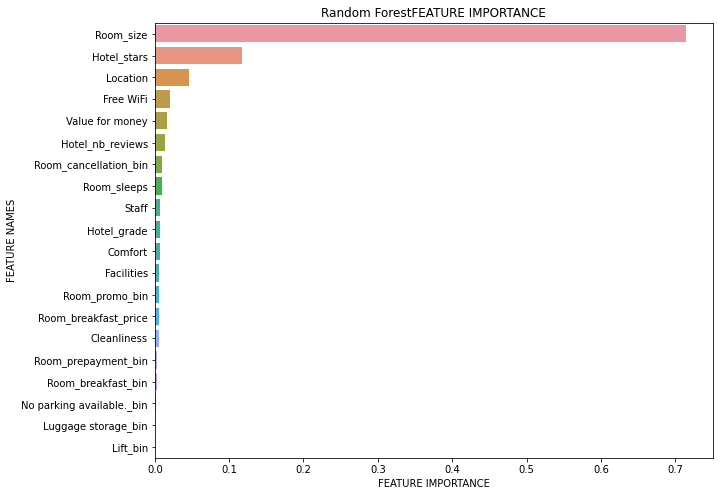

In [91]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(best_model.feature_importances_, X_tr.columns, 'Random Forest')

# Exploitation du prédicteur 

In [34]:
best_model = rfr_gs_final
y_true, y_pred = y_te, best_model.predict(X_te)

true=np.array(y_true)
pred=np.array(y_pred)
pred=np.around(pred, decimals=1)

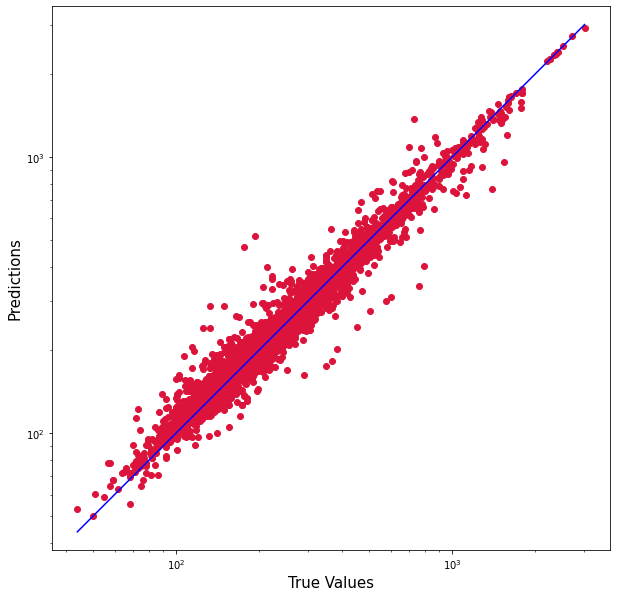

In [39]:
true_pred_plot(true, pred)

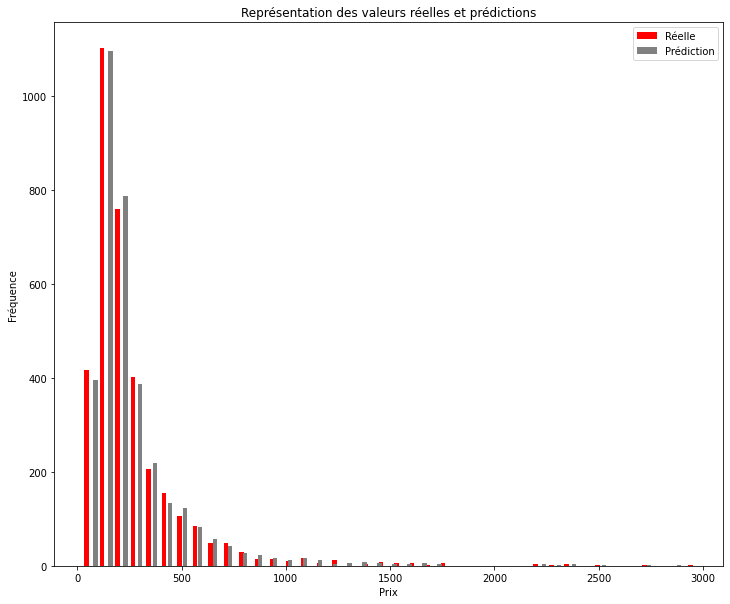

In [87]:
plt.figure(figsize=(12,10))
plt.hist(true,align="left",bins=40, rwidth=0.3,color='red',label="Réelle")
plt.hist(pred,align="mid",bins=40, rwidth=0.3,color='grey',label="Prédiction")
plt.title("Représentation des valeurs réelles et prédictions")
plt.xlabel("Prix")
plt.ylabel("Fréquence")
plt.legend()
plt.show()